# Basic imports
---

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import random
%matplotlib inline

import urllib.request
from PIL import Image
import io

import cv2

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

import torchvision
from torchvision.datasets import MNIST, CIFAR10

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

# Download and process the data set
---



## Download from github

In [2]:
# !git clone https://github.com/octavio-navarro/DL_Data_sets.git

## Show an image from the data set

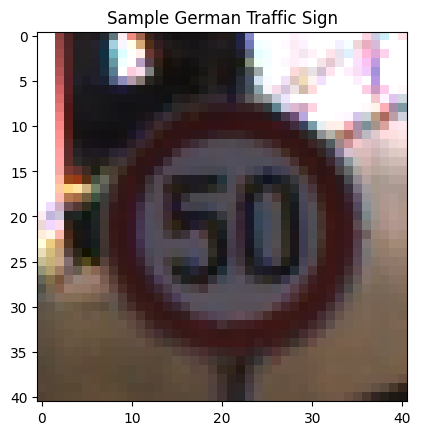

In [3]:
# Load and display a sample image from the German Traffic Signs dataset
image = cv2.imread('Data_Tarea2/German_Traffic_signs/Images/00002/00005_00015.ppm')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display

plt.imshow(image)
plt.title('Sample German Traffic Sign')
plt.show()


## Separates the data into different folders

In [4]:
# Split the German Traffic Signs dataset into train and test directories
# Dataset organization: 43 classes (00000-00042), each containing traffic sign images
# Split ratio: 80% training, 20% testing

original_images_path = 'Data_Tarea2/German_Traffic_signs/Images'
new_base_path = 'Data_Tarea2/German_Traffic_signs_Split'

# Remove existing split directory to avoid duplicate images
if os.path.exists(new_base_path):
    print(f"Removing existing directory: {new_base_path}")
    shutil.rmtree(new_base_path)
    print("Directory removed successfully.\n")

# Create main train and test directories
os.makedirs(os.path.join(new_base_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(new_base_path, 'test'), exist_ok=True)

print(f"Created base directories: {os.path.join(new_base_path, 'train')} and {os.path.join(new_base_path, 'test')}")

# Get all class directories (43 traffic sign classes)
class_directories = sorted([d for d in os.listdir(original_images_path) 
                           if os.path.isdir(os.path.join(original_images_path, d))])

# Process each class
for class_name in class_directories:
    class_original_path = os.path.join(original_images_path, class_name)
    train_class_path = os.path.join(new_base_path, 'train', class_name)
    test_class_path = os.path.join(new_base_path, 'test', class_name)

    # Create class subdirectories within train and test
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Get all image files for current class
    all_images = glob.glob(os.path.join(class_original_path, '*.ppm'))
    random.shuffle(all_images)

    # Split into 80% train, 20% test
    split_point = int(0.8 * len(all_images))
    train_images = all_images[:split_point]
    test_images = all_images[split_point:]

    # Copy images to respective directories
    for img_src in train_images:
        shutil.copy(img_src, os.path.join(train_class_path, os.path.basename(img_src)))

    for img_src in test_images:
        shutil.copy(img_src, os.path.join(test_class_path, os.path.basename(img_src)))

    print(f"Class {class_name}: {len(train_images)} train images, {len(test_images)} test images")

print("\nData splitting complete!")

# Verify split for a sample class
print("\nVerifying split for class '00000':")
sample_class = '00000'
if sample_class in class_directories:
    train_count = len(os.listdir(os.path.join(new_base_path, 'train', sample_class)))
    test_count = len(os.listdir(os.path.join(new_base_path, 'test', sample_class)))
    print(f"Train images: {train_count}")
    print(f"Test images: {test_count}")


Created base directories: Data_Tarea2/German_Traffic_signs_Split/train and Data_Tarea2/German_Traffic_signs_Split/test
Class 00000: 168 train images, 42 test images
Class 00001: 1776 train images, 444 test images
Class 00001: 1776 train images, 444 test images
Class 00002: 1800 train images, 450 test images
Class 00002: 1800 train images, 450 test images
Class 00003: 1128 train images, 282 test images
Class 00003: 1128 train images, 282 test images
Class 00004: 1584 train images, 396 test images
Class 00004: 1584 train images, 396 test images
Class 00005: 1488 train images, 372 test images
Class 00006: 336 train images, 84 test images
Class 00005: 1488 train images, 372 test images
Class 00006: 336 train images, 84 test images
Class 00007: 1152 train images, 288 test images
Class 00007: 1152 train images, 288 test images
Class 00008: 1128 train images, 282 test images
Class 00008: 1128 train images, 282 test images
Class 00009: 1176 train images, 294 test images
Class 00009: 1176 train

# Model definition with transfer learning
---

## Define a model to classify the images. **Use transfer learning for this step, but don't use fine-tuning.**


In [5]:
# Load ResNet18 architecture without pretrained weights
# This model will be customized for German Traffic Signs classification (43 classes)
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=False)


Using cache found in /Users/gabrieledid/.cache/torch/hub/pytorch_vision_main
/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
class GermanSignsCnnModel(L.LightningModule):
    """
    PyTorch Lightning module for German Traffic Signs classification.
    
    Wraps a CNN model (ResNet18) and handles training, validation, and testing logic.
    Tracks accuracy metrics for all three stages.
    """
    
    def __init__(self, model, learning_rate, num_classes=43):
        """
        Initialize the model.
        
        Args:
            model (torch.nn.Module): The CNN architecture to use (ResNet18)
            learning_rate (float): Learning rate for optimizer
            num_classes (int): Number of traffic sign classes (default: 43)
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.num_classes = num_classes

        # Initialize accuracy metrics for each stage
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        """Forward pass through the model."""
        return self.model(x)

    def _shared_step(self, batch):
        """
        Shared logic for train/val/test steps.
        
        Returns:
            loss: Cross-entropy loss
            true_labels: Ground truth labels
            predicted_labels: Model predictions
        """
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        """
        Training step - compute loss and accuracy.
        
        Logs:
            - train_loss: Cross-entropy loss for training
            - train_acc: Training accuracy per epoch
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step - evaluate model on validation set.
        
        Logs:
            - val_loss: Validation loss
            - val_acc: Validation accuracy
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        """
        Test step - final evaluation on test set.
        
        Logs:
            - test_acc: Test set accuracy
        """
        with torch.no_grad():
            loss, true_labels, predicted_labels = self._shared_step(batch)
            self.test_acc(predicted_labels, true_labels)
            self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        """Configure RMSprop optimizer for training."""
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

In [7]:
class GermanSignsDataModule(L.LightningDataModule):
    """
    PyTorch Lightning DataModule for German Traffic Signs dataset.
    
    Handles data loading, preprocessing, and creates dataloaders for train/val/test.
    Uses ImageFolder to automatically load images organized in class subdirectories.
    """
    
    def __init__(self, data_path, batch_size=64, num_workers=0, train_transform=None, test_transform=None):
        """
        Initialize the DataModule.
        
        Args:
            data_path (str): Path to directory containing 'train' and 'test' folders
            batch_size (int): Batch size for dataloaders
            num_workers (int): Number of workers for parallel data loading
            train_transform: Transformations for training data (with augmentation)
            test_transform: Transformations for test/validation data (no augmentation)
        """
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform

    def prepare_data(self):
        """Data is already downloaded and organized - no action needed."""
        pass

    def setup(self, stage=None):
        """
        Load datasets and split training data into train/validation sets.
        
        Split: 90% training, 10% validation (from the training folder)
        Test set is loaded separately from the test folder
        """

        train_path = os.path.join(self.data_path, 'train')
        test_path = os.path.join(self.data_path, 'test')

        # Load full training dataset
        full_train = ImageFolder(
            root=train_path,
            transform=self.train_transform
        )

        # Load test dataset
        self.test = ImageFolder(
            root=test_path,
            transform=self.test_transform
        )

        # Split training data: 90% train, 10% validation
        train_size = int(0.9 * len(full_train))
        val_size = len(full_train) - train_size
        self.train, self.valid = random_split(full_train, lengths=[train_size, val_size])

        print(f"Training samples: {len(self.train)}")
        print(f"Validation samples: {len(self.valid)}")
        print(f"Test samples: {len(self.test)}")
        print(f"Number of classes: {len(full_train.classes)}")

    def train_dataloader(self):
        """Create training dataloader with shuffling."""
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        """Create validation dataloader without shuffling."""
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return valid_loader

    def test_dataloader(self):
        """Create test dataloader without shuffling."""
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader


In [8]:
# Define transformations for training and testing
# Using ImageNet normalization values since we're using a pretrained ResNet
model_transform = Compose([
    Resize((224, 224)),  # ResNet18 expects 224x224 images
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

print("Basic model transformation defined (resize + normalize with ImageNet stats)")
print("This will be used for both training and testing initially.")
print("\nNote: Data augmentation transforms are defined in a separate cell below.")

Basic model transformation defined (resize + normalize with ImageNet stats)
This will be used for both training and testing initially.

Note: Data augmentation transforms are defined in a separate cell below.


## Define the data augmentation transformations for the data loaders.

In [9]:
# Define data augmentation transformations for training and testing

# Training transformations - includes augmentation to improve model generalization
train_transform = Compose([
    Resize((224, 224)),  # Resize to ResNet18 input size
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translations
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Lighting variations
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Random sharpness adjustment
    ToTensor(),  # Convert to PyTorch tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Test/validation transformations - no augmentation, only resize and normalize
test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Training transformations (with augmentation):")
print(train_transform)
print("\nTest/Validation transformations (no augmentation):")
print(test_transform)


Training transformations (with augmentation):
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=None)
    RandomAdjustSharpness(sharpness_factor=2,p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Test/Validation transformations (no augmentation):
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Define the train, validation, and test dataloaders

In [10]:
# Create DataModule with augmented training transforms
data_path = 'Data_Tarea2/German_Traffic_signs_Split'

data_module = GermanSignsDataModule(
    data_path=data_path,
    batch_size=32,
    num_workers=2,
    train_transform=train_transform,  # Training: with augmentation
    test_transform=test_transform      # Test/validation: without augmentation
)

# Setup the data module (loads and splits datasets)
data_module.setup()

# Create dataloaders for each stage
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

# Display dataset statistics
print(f"\nDataloader Statistics:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {data_module.batch_size}")
print(f"  Images per training epoch: {len(train_loader) * data_module.batch_size}")


Training samples: 28230
Validation samples: 3137
Test samples: 7842
Number of classes: 43

Dataloader Statistics:
  Train batches: 882
  Validation batches: 99
  Test batches: 246
  Batch size: 32
  Images per training epoch: 28224


## Using matplotlib, visualize images from the train dataloader. Create a figure of 20 images, with 5 images per row.

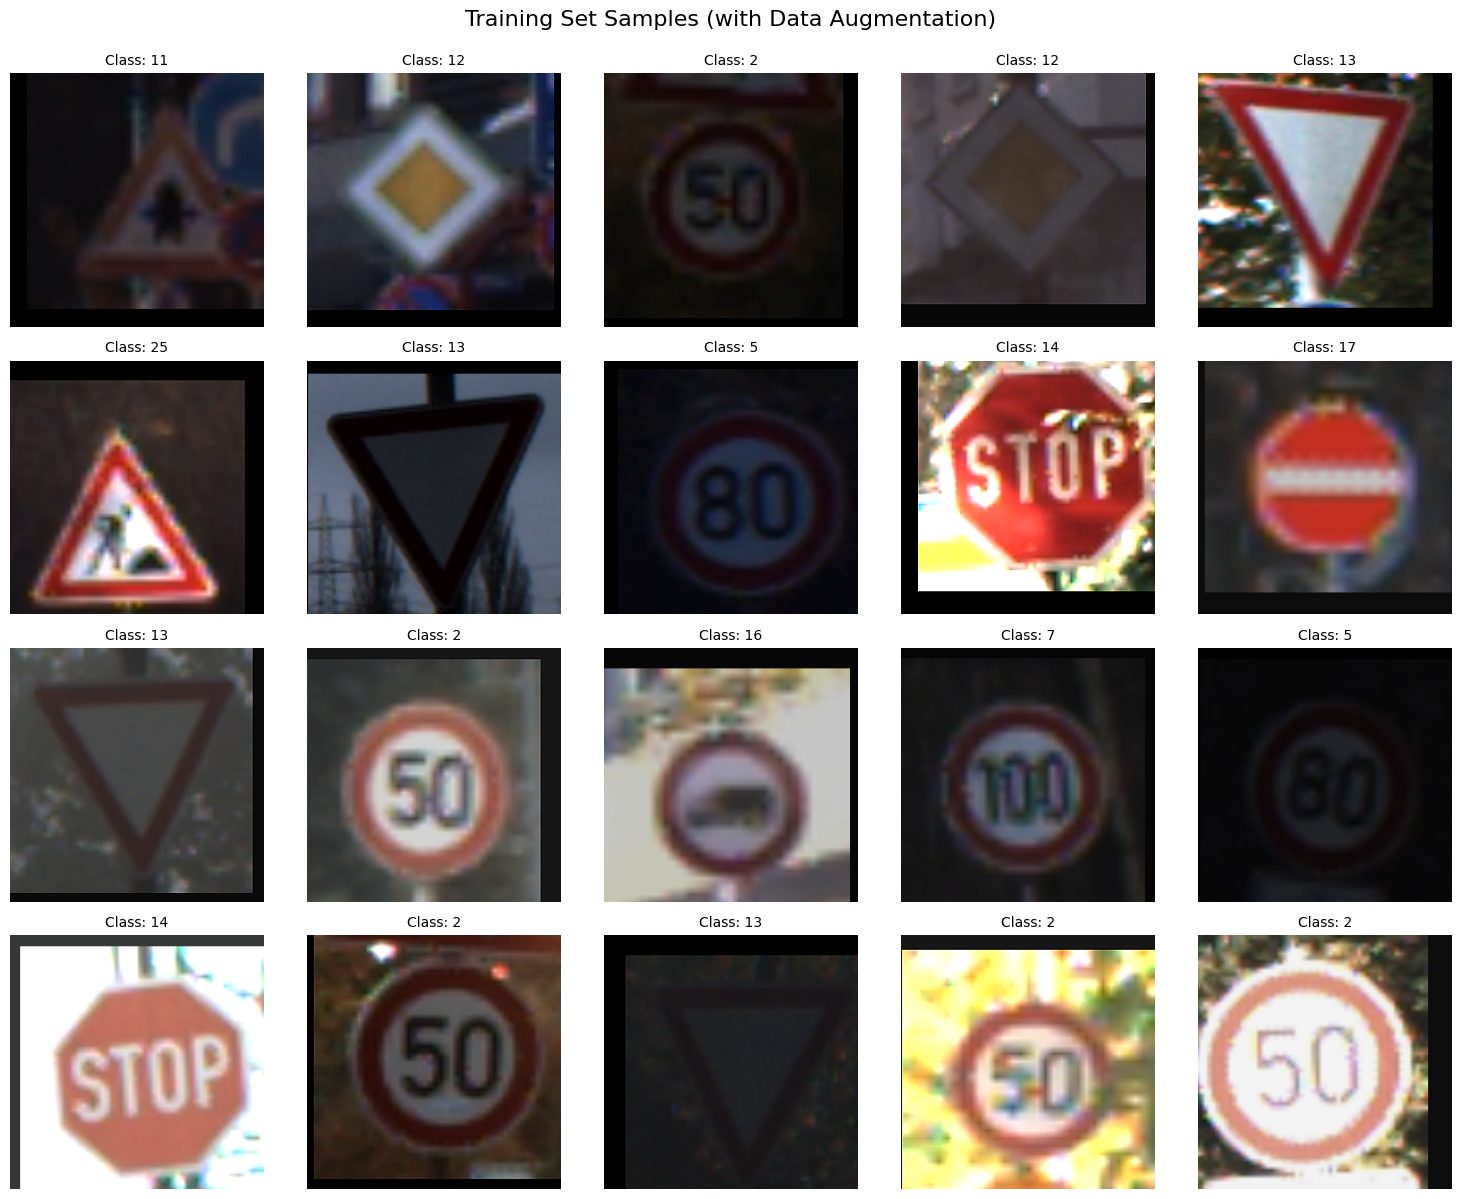


Displayed 20 augmented training images
Augmentation effects visible: translation, color jitter, sharpness variation


In [11]:
# Visualize sample images from the training set with augmentation applied

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Denormalization parameters (reverse ImageNet normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    """Reverse normalization for visualization."""
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    return img

# Create figure with 4 rows and 5 columns (20 images)
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Training Set Samples (with Data Augmentation)', fontsize=16, y=0.995)

# Display 20 images
for idx in range(20):
    row = idx // 5
    col = idx % 5

    # Denormalize and convert to displayable format
    img = denormalize(images[idx])
    img_np = img.permute(1, 2, 0).numpy()

    # Display image with class label
    axes[row, col].imshow(img_np)
    axes[row, col].set_title(f'Class: {labels[idx].item()}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"\nDisplayed 20 augmented training images")
print(f"Augmentation effects visible: translation, color jitter, sharpness variation")


## Train the model. Use model checkpoints and early stopping during training. **Don't forget to use a GPU for training.**

In [12]:
# Load ResNet18 without pretrained weights
resnet_model = resnet18(weights=None)

# Ensure all parameters are trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# Replace final layer for 43 classes (German Traffic Signs)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 43)

# Create Lightning model wrapper
german_signs_model = GermanSignsCnnModel(model=resnet_model, learning_rate=0.001)

# Detect available accelerator (MPS for Mac, CUDA for NVIDIA GPU, or CPU)
if torch.backends.mps.is_available():
    accelerator = 'mps'
    device_name = 'Apple Metal (MPS)'
elif torch.cuda.is_available():
    accelerator = 'gpu'
    device_name = f'CUDA - {torch.cuda.get_device_name(0)}'
else:
    accelerator = 'cpu'
    device_name = 'CPU'

# Configure trainer with callbacks for monitoring and saving
trainer = L.Trainer(
    max_epochs=20,
    accelerator=accelerator,
    devices=1,
    logger=CSVLogger(save_dir="Data_Tarea2/logs/", name="german-signs-no-finetuning"),
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=3,  # Stop if no improvement for 3 epochs
            verbose=True
        ),
        ModelCheckpoint(
            monitor="val_acc",
            mode="max",
            save_top_k=1,  # Save only the best model
            filename='best-model-no-finetuning'
        )
    ],
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True
)

# Display training configuration
print(f"Using device: {device_name}")
print(f"Accelerator: {accelerator.upper()}")
print(f"\nTraining Configuration:")
print(f"   Strategy: Training from scratch (no pretrained weights)")
print(f"   All layers: TRAINABLE")
print(f"   Total parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")
print(f"   Learning rate: 0.001")
print(f"\nEarly Stopping:")
print(f"   Monitoring: val_loss")
print(f"   Patience: 3 epochs")
print(f"   Purpose: Prevent overfitting by stopping when validation loss plateaus")
print(f"\nStarting training...")

# Train the model
trainer.fit(german_signs_model, data_module)

# Display results
print("\n" + "="*70)
print("Training completed!")
print(f"Best model saved: {trainer.checkpoint_callback.best_model_path}")
print(f"Best validation accuracy: {trainer.checkpoint_callback.best_model_score:.4f}")
print("="*70)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores


Using device: Apple Metal (MPS)
Accelerator: MPS

Training Configuration:
   Strategy: Training from scratch (no pretrained weights)
   All layers: TRAINABLE
   Total parameters: 11,198,571
   Learning rate: 0.001

Early Stopping:
   Monitoring: val_loss
   Patience: 3 epochs
   Purpose: Prevent overfitting by stopping when validation loss plateaus

Starting training...
Training samples: 28230
Validation samples: 3137
Test samples: 7842
Number of classes: 43



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.794    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 882/882 [03:35<00:00,  4.10it/s, v_num=0, val_loss=1.350, val_acc=0.543, train_acc=0.344]

Metric val_loss improved. New best score: 1.353


Epoch 1: 100%|██████████| 882/882 [03:45<00:00,  3.91it/s, v_num=0, val_loss=0.226, val_acc=0.933, train_acc=0.871]

Metric val_loss improved by 1.127 >= min_delta = 0.0. New best score: 0.226


Epoch 3: 100%|██████████| 882/882 [03:46<00:00,  3.90it/s, v_num=0, val_loss=0.215, val_acc=0.935, train_acc=0.982]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.215


Epoch 4: 100%|██████████| 882/882 [03:43<00:00,  3.95it/s, v_num=0, val_loss=0.0624, val_acc=0.978, train_acc=0.986]

Metric val_loss improved by 0.152 >= min_delta = 0.0. New best score: 0.062


Epoch 5: 100%|██████████| 882/882 [03:45<00:00,  3.92it/s, v_num=0, val_loss=0.0339, val_acc=0.990, train_acc=0.989]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.034


Epoch 6: 100%|██████████| 882/882 [03:45<00:00,  3.91it/s, v_num=0, val_loss=0.0169, val_acc=0.995, train_acc=0.992]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.017


Epoch 9: 100%|██████████| 882/882 [03:39<00:00,  4.01it/s, v_num=0, val_loss=0.0458, val_acc=0.986, train_acc=0.996]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.017. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 882/882 [03:39<00:00,  4.01it/s, v_num=0, val_loss=0.0458, val_acc=0.986, train_acc=0.996]


Training completed!
Best model saved: Data_Tarea2/logs/german-signs-no-finetuning/version_0/checkpoints/best-model-no-finetuning.ckpt
Best validation accuracy: 0.9952

Training completed!
Best model saved: Data_Tarea2/logs/german-signs-no-finetuning/version_0/checkpoints/best-model-no-finetuning.ckpt
Best validation accuracy: 0.9952


## Model evaluation
---

### Evaluate the performance of the model with the test dataloader.

In [13]:
# Evaluate the trained model on the test dataset

print("=" * 60)
print("EVALUATING MODEL ON TEST SET")
print("=" * 60)

# Run test evaluation
test_results = trainer.test(german_signs_model, datamodule=data_module)

# Extract test accuracy
test_acc = test_results[0]['test_acc']

print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("=" * 60)

# Load and test the best checkpoint (highest validation accuracy)
print("\n" + "=" * 60)
print("TESTING BEST MODEL FROM CHECKPOINT")
print("=" * 60)

best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")

# Load the best saved model
best_model = GermanSignsCnnModel.load_from_checkpoint(
    best_model_path,
    model=resnet_model,
    learning_rate=0.001
)

# Test the best model
best_test_results = trainer.test(best_model, datamodule=data_module)
best_test_acc = best_test_results[0]['test_acc']

print(f"\nBest Model Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print("=" * 60)


EVALUATING MODEL ON TEST SET
Training samples: 28230
Validation samples: 3137
Test samples: 7842
Number of classes: 43


/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 246/246 [00:14<00:00, 16.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.98916095495224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.98916095495224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

TEST SET RESULTS
Tes

### Plot the results of training: plot training and validation accuracy, and loss.

Loaded metrics from: Data_Tarea2/logs/german-signs-no-finetuning/version_0/metrics.csv
Available columns: ['epoch', 'step', 'test_acc', 'train_acc', 'train_loss', 'val_acc', 'val_loss']

Total epochs trained: 10


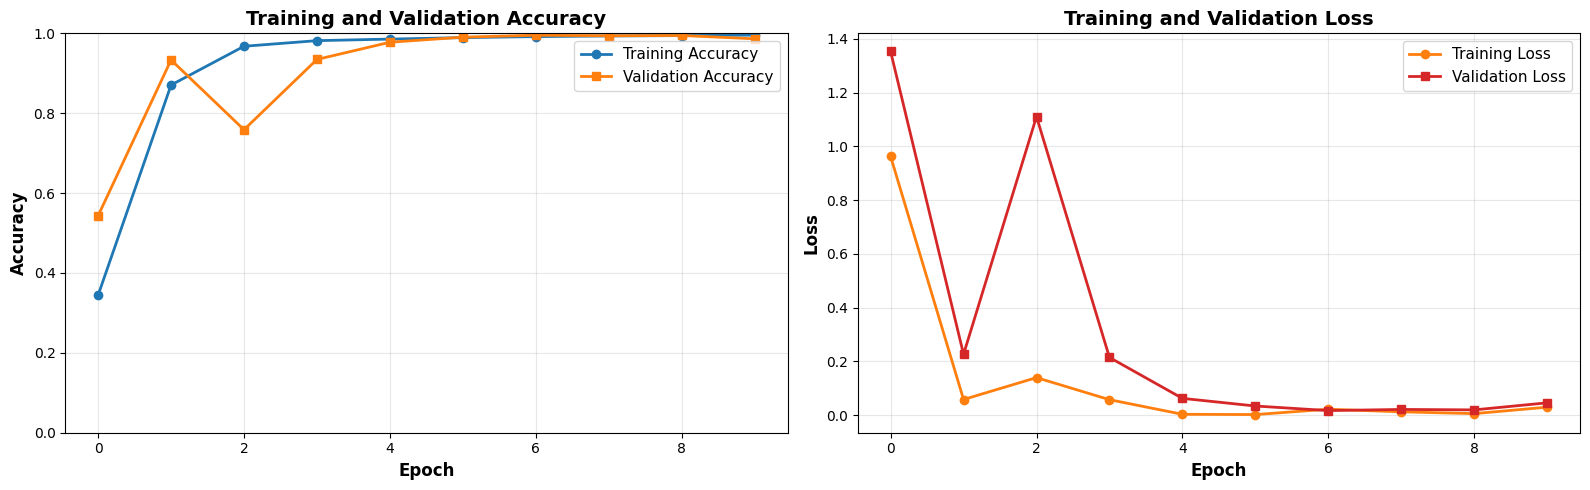


TRAINING SUMMARY
Final Training Accuracy: 0.9956
Final Validation Accuracy: 0.9863
Final Training Loss: 0.0296
Final Validation Loss: 0.0458

Best Validation Accuracy: 0.9952 (Epoch 6)
Best Validation Loss: 0.0169 (Epoch 6)


In [20]:
# Plot training and validation curves

# Load metrics from CSV logger
metrics_path = os.path.join(trainer.logger.log_dir, "metrics.csv")
metrics_df = pd.read_csv(metrics_path)

print(f"Loaded metrics from: {metrics_path}")
print(f"Available columns: {metrics_df.columns.tolist()}\n")

# Remove step-level logs (keep only epoch-level metrics)
metrics_df = metrics_df.dropna(subset=['epoch'])

# Group by epoch and aggregate properly - use first non-null value for each metric
epoch_metrics = metrics_df.groupby('epoch').agg({
    'train_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'train_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan
}).reset_index()

# Remove any remaining NaN rows
epoch_metrics = epoch_metrics.dropna(subset=['train_acc', 'val_acc', 'train_loss', 'val_loss'], how='all')

print(f"Total epochs trained: {len(epoch_metrics)}")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Training and Validation Accuracy
ax1 = axes[0]
if 'train_acc' in epoch_metrics.columns and not epoch_metrics['train_acc'].isna().all():
    ax1.plot(epoch_metrics['epoch'], epoch_metrics['train_acc'], 
             marker='o', label='Training Accuracy', linewidth=2, markersize=6)
if 'val_acc' in epoch_metrics.columns and not epoch_metrics['val_acc'].isna().all():
    ax1.plot(epoch_metrics['epoch'], epoch_metrics['val_acc'], 
             marker='s', label='Validation Accuracy', linewidth=2, markersize=6)

ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Training and Validation Loss
ax2 = axes[1]
if 'train_loss' in epoch_metrics.columns and not epoch_metrics['train_loss'].isna().all():
    ax2.plot(epoch_metrics['epoch'], epoch_metrics['train_loss'], 
             marker='o', label='Training Loss', linewidth=2, markersize=6, color='#ff7f0e')
if 'val_loss' in epoch_metrics.columns and not epoch_metrics['val_loss'].isna().all():
    ax2.plot(epoch_metrics['epoch'], epoch_metrics['val_loss'], 
             marker='s', label='Validation Loss', linewidth=2, markersize=6, color='#d62728')

ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

# Check if metrics exist and are not empty
if len(epoch_metrics) > 0 and 'train_acc' in epoch_metrics.columns and not epoch_metrics['train_acc'].isna().all():
    print(f"Final Training Accuracy: {epoch_metrics['train_acc'].iloc[-1]:.4f}")
    print(f"Final Validation Accuracy: {epoch_metrics['val_acc'].iloc[-1]:.4f}")
    print(f"Final Training Loss: {epoch_metrics['train_loss'].iloc[-1]:.4f}")
    print(f"Final Validation Loss: {epoch_metrics['val_loss'].iloc[-1]:.4f}")
    print(f"\nBest Validation Accuracy: {epoch_metrics['val_acc'].max():.4f} (Epoch {epoch_metrics.loc[epoch_metrics['val_acc'].idxmax(), 'epoch']:.0f})")
    print(f"Best Validation Loss: {epoch_metrics['val_loss'].min():.4f} (Epoch {epoch_metrics.loc[epoch_metrics['val_loss'].idxmin(), 'epoch']:.0f})")
else:
    print("Warning: No valid training metrics found!")
    print("This usually means:")
    print("  - Training cell was not executed")
    print("  - Training did not complete")
    print("  - Metrics file is empty or corrupted")
    print("\nPlease run the training cell first.")

print("="*60)

# Model using Transfer Learning and fine-tuning
---

Create a model using transfer learning, data augmentation, and fine-tuning, train the model, and do predictions with it on the test dataset.

## Make and train a new model using transfer learning and fine-tuning.


In [15]:
# Load ResNet18 with pretrained ImageNet weights
resnet_model_ft = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all parameters initially
for param in resnet_model_ft.parameters():
    param.requires_grad = False

# Unfreeze the last convolutional block (layer4) for fine-tuning
for param in resnet_model_ft.layer4.parameters():
    param.requires_grad = True

# Replace final layer for 43 classes (automatically trainable)
num_features_ft = resnet_model_ft.fc.in_features
resnet_model_ft.fc = nn.Linear(num_features_ft, 43)

# Create Lightning model with lower learning rate
german_signs_model_ft = GermanSignsCnnModel(model=resnet_model_ft, learning_rate=0.0001)

# Detect available accelerator
if torch.backends.mps.is_available():
    accelerator = 'mps'
    device_name = 'Apple Metal (MPS)'
elif torch.cuda.is_available():
    accelerator = 'gpu'
    device_name = f'CUDA - {torch.cuda.get_device_name(0)}'
else:
    accelerator = 'cpu'
    device_name = 'CPU'

# Configure trainer with same callbacks
trainer_ft = L.Trainer(
    max_epochs=20,
    accelerator=accelerator,
    devices=1,
    logger=CSVLogger(save_dir="Data_Tarea2/logs/", name="german-signs-with-finetuning"),
    callbacks=[
         EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=3,
            verbose=True
        ),
        ModelCheckpoint(
            monitor="val_acc",
            mode="max",
            save_top_k=1,
            filename='best-model-finetuning'
        )
    ],
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True
)

# Calculate parameter statistics
trainable_params = sum(p.numel() for p in resnet_model_ft.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in resnet_model_ft.parameters() if not p.requires_grad)
total_params = trainable_params + frozen_params

# Display training configuration
print(f"Using device: {device_name}")
print(f"Accelerator: {accelerator.upper()}")
print(f"\nTraining Configuration:")
print(f"   Strategy: Transfer learning with fine-tuning")
print(f"   Early layers (conv1-layer3): FROZEN")
print(f"   Last conv block (layer4): TRAINABLE")
print(f"   Final FC layer: TRAINABLE")
print(f"   Learning rate: 0.0001 (10x lower for stability)")
print(f"\nParameter Distribution:")
print(f"   Trainable: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
print(f"   Frozen: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")
print(f"   Total: {total_params:,}")
print(f"\nEarly Stopping:")
print(f"   Monitoring: val_loss")
print(f"   Patience: 3 epochs")
print(f"\nStarting fine-tuning...")

# Train the model
trainer_ft.fit(german_signs_model_ft, data_module)

# Display results
print("\n" + "="*70)
print("Fine-tuning completed!")
print(f"Best model saved: {trainer_ft.checkpoint_callback.best_model_path}")
print(f"Best validation accuracy: {trainer_ft.checkpoint_callback.best_model_score:.4f}")
print("="*70)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores


Using device: Apple Metal (MPS)
Accelerator: MPS

Training Configuration:
   Strategy: Transfer learning with fine-tuning
   Early layers (conv1-layer3): FROZEN
   Last conv block (layer4): TRAINABLE
   Final FC layer: TRAINABLE
   Learning rate: 0.0001 (10x lower for stability)

Parameter Distribution:
   Trainable: 8,415,787 (75.2%)
   Frozen: 2,782,784 (24.8%)
   Total: 11,198,571

Early Stopping:
   Monitoring: val_loss
   Patience: 3 epochs

Starting fine-tuning...



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.794    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Training samples: 28230
Validation samples: 3137
Test samples: 7842
Number of classes: 43
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 882/882 [01:41<00:00,  8.68it/s, v_num=0, val_loss=0.0739, val_acc=0.977, train_acc=0.921]

Metric val_loss improved. New best score: 0.074


Epoch 1: 100%|██████████| 882/882 [01:58<00:00,  7.45it/s, v_num=0, val_loss=0.039, val_acc=0.989, train_acc=0.982] 

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.039


Epoch 2: 100%|██████████| 882/882 [01:50<00:00,  7.97it/s, v_num=0, val_loss=0.0358, val_acc=0.989, train_acc=0.989]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.036


Epoch 3: 100%|██████████| 882/882 [01:51<00:00,  7.91it/s, v_num=0, val_loss=0.034, val_acc=0.989, train_acc=0.992] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.034


Epoch 4: 100%|██████████| 882/882 [01:54<00:00,  7.73it/s, v_num=0, val_loss=0.0212, val_acc=0.993, train_acc=0.993]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.021


Epoch 6: 100%|██████████| 882/882 [01:51<00:00,  7.92it/s, v_num=0, val_loss=0.0178, val_acc=0.993, train_acc=0.995]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.018


Epoch 7: 100%|██████████| 882/882 [01:51<00:00,  7.90it/s, v_num=0, val_loss=0.0141, val_acc=0.996, train_acc=0.996]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.014


Epoch 8: 100%|██████████| 882/882 [01:52<00:00,  7.85it/s, v_num=0, val_loss=0.0132, val_acc=0.996, train_acc=0.996]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.013


Epoch 11: 100%|██████████| 882/882 [01:52<00:00,  7.82it/s, v_num=0, val_loss=0.0186, val_acc=0.993, train_acc=0.998]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.013. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 882/882 [01:52<00:00,  7.82it/s, v_num=0, val_loss=0.0186, val_acc=0.993, train_acc=0.998]


Fine-tuning completed!
Best model saved: Data_Tarea2/logs/german-signs-with-finetuning/version_0/checkpoints/best-model-finetuning.ckpt
Best validation accuracy: 0.9965

Fine-tuning completed!
Best model saved: Data_Tarea2/logs/german-signs-with-finetuning/version_0/checkpoints/best-model-finetuning.ckpt
Best validation accuracy: 0.9965


## Plot the results of training and evaluation

EVALUATING FINE-TUNED MODEL ON TEST SET
Training samples: 28230
Validation samples: 3137
Test samples: 7842
Number of classes: 43


/Users/gabrieledid/Desktop/Tec/Concentracion-Inteligencia-Artificial/Bloque2/env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 246/246 [00:15<00:00, 15.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9954093098640442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9954093098640442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Fine-tuned Model T

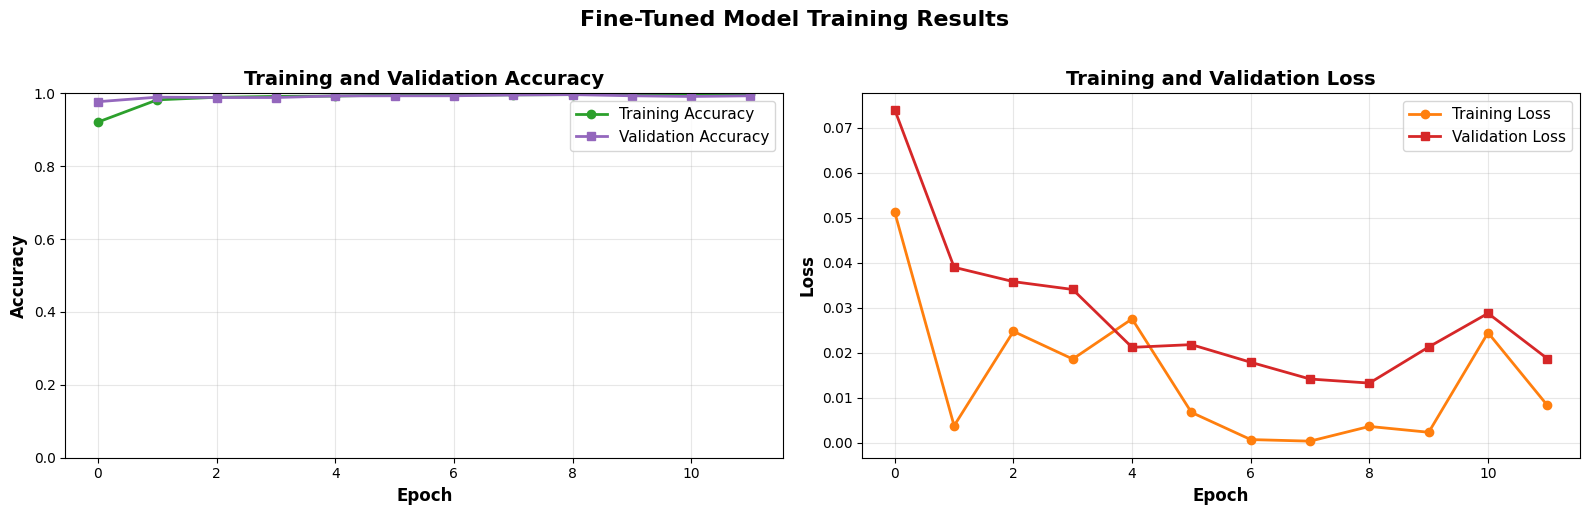


FINE-TUNING TRAINING SUMMARY
Final Training Accuracy: 0.9976
Final Validation Accuracy: 0.9933
Final Training Loss: 0.0083
Final Validation Loss: 0.0186

Best Validation Accuracy: 0.9965 (Epoch 8)
Best Validation Loss: 0.0132 (Epoch 8)

Test Accuracy: 0.9954 (99.54%)


In [21]:
# Evaluate and plot results for the fine-tuned model

print("=" * 60)
print("EVALUATING FINE-TUNED MODEL ON TEST SET")
print("=" * 60)

# Run test evaluation
test_results_ft = trainer_ft.test(german_signs_model_ft, datamodule=data_module)
test_acc_ft = test_results_ft[0]['test_acc']

print(f"\nFine-tuned Model Test Accuracy: {test_acc_ft:.4f} ({test_acc_ft*100:.2f}%)")
print("=" * 60)

# Load and plot training metrics
metrics_path_ft = os.path.join(trainer_ft.logger.log_dir, "metrics.csv")
metrics_df_ft = pd.read_csv(metrics_path_ft)

print(f"\nLoaded fine-tuning metrics from: {metrics_path_ft}")

# Clean and process data
metrics_df_ft = metrics_df_ft.dropna(subset=['epoch'])

# Group by epoch and aggregate properly - use last non-null value for each metric
epoch_metrics_ft = metrics_df_ft.groupby('epoch').agg({
    'train_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'train_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan
}).reset_index()

# Remove any remaining NaN rows
epoch_metrics_ft = epoch_metrics_ft.dropna(subset=['train_acc', 'val_acc', 'train_loss', 'val_loss'], how='all')

print(f"Total epochs trained: {len(epoch_metrics_ft)}")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Fine-Tuned Model Training Results', fontsize=16, fontweight='bold', y=1.02)

# Plot 1: Accuracy
ax1 = axes[0]
if 'train_acc' in epoch_metrics_ft.columns and not epoch_metrics_ft['train_acc'].isna().all():
    ax1.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['train_acc'], 
             marker='o', label='Training Accuracy', linewidth=2, markersize=6, color='#2ca02c')
if 'val_acc' in epoch_metrics_ft.columns and not epoch_metrics_ft['val_acc'].isna().all():
    ax1.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['val_acc'], 
             marker='s', label='Validation Accuracy', linewidth=2, markersize=6, color='#9467bd')

ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss
ax2 = axes[1]
if 'train_loss' in epoch_metrics_ft.columns and not epoch_metrics_ft['train_loss'].isna().all():
    ax2.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['train_loss'], 
             marker='o', label='Training Loss', linewidth=2, markersize=6, color='#ff7f0e')
if 'val_loss' in epoch_metrics_ft.columns and not epoch_metrics_ft['val_loss'].isna().all():
    ax2.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['val_loss'], 
             marker='s', label='Validation Loss', linewidth=2, markersize=6, color='#d62728')

ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("FINE-TUNING TRAINING SUMMARY")
print("="*60)

# Check if metrics exist and are not empty
if len(epoch_metrics_ft) > 0 and 'train_acc' in epoch_metrics_ft.columns and not epoch_metrics_ft['train_acc'].isna().all():
    print(f"Final Training Accuracy: {epoch_metrics_ft['train_acc'].iloc[-1]:.4f}")
    print(f"Final Validation Accuracy: {epoch_metrics_ft['val_acc'].iloc[-1]:.4f}")
    print(f"Final Training Loss: {epoch_metrics_ft['train_loss'].iloc[-1]:.4f}")
    print(f"Final Validation Loss: {epoch_metrics_ft['val_loss'].iloc[-1]:.4f}")
    print(f"\nBest Validation Accuracy: {epoch_metrics_ft['val_acc'].max():.4f} (Epoch {epoch_metrics_ft.loc[epoch_metrics_ft['val_acc'].idxmax(), 'epoch']:.0f})")
    print(f"Best Validation Loss: {epoch_metrics_ft['val_loss'].min():.4f} (Epoch {epoch_metrics_ft.loc[epoch_metrics_ft['val_loss'].idxmin(), 'epoch']:.0f})")
    print(f"\nTest Accuracy: {test_acc_ft:.4f} ({test_acc_ft*100:.2f}%)")
else:
    print("Warning: No valid training metrics found!")
    print("This usually means:")
    print("  - Training cell was not executed")
    print("  - Training did not complete")
    print("  - Metrics file is empty or corrupted")
    print("\nPlease run the fine-tuning training cell first.")
    print(f"\nTest Accuracy (from test run): {test_acc_ft:.4f} ({test_acc_ft*100:.2f}%)")

print("="*60)

## Makes predictions using the test dataset

Selecting one image from different classes...
Selected 20 images from different classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Selected 20 images from different classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


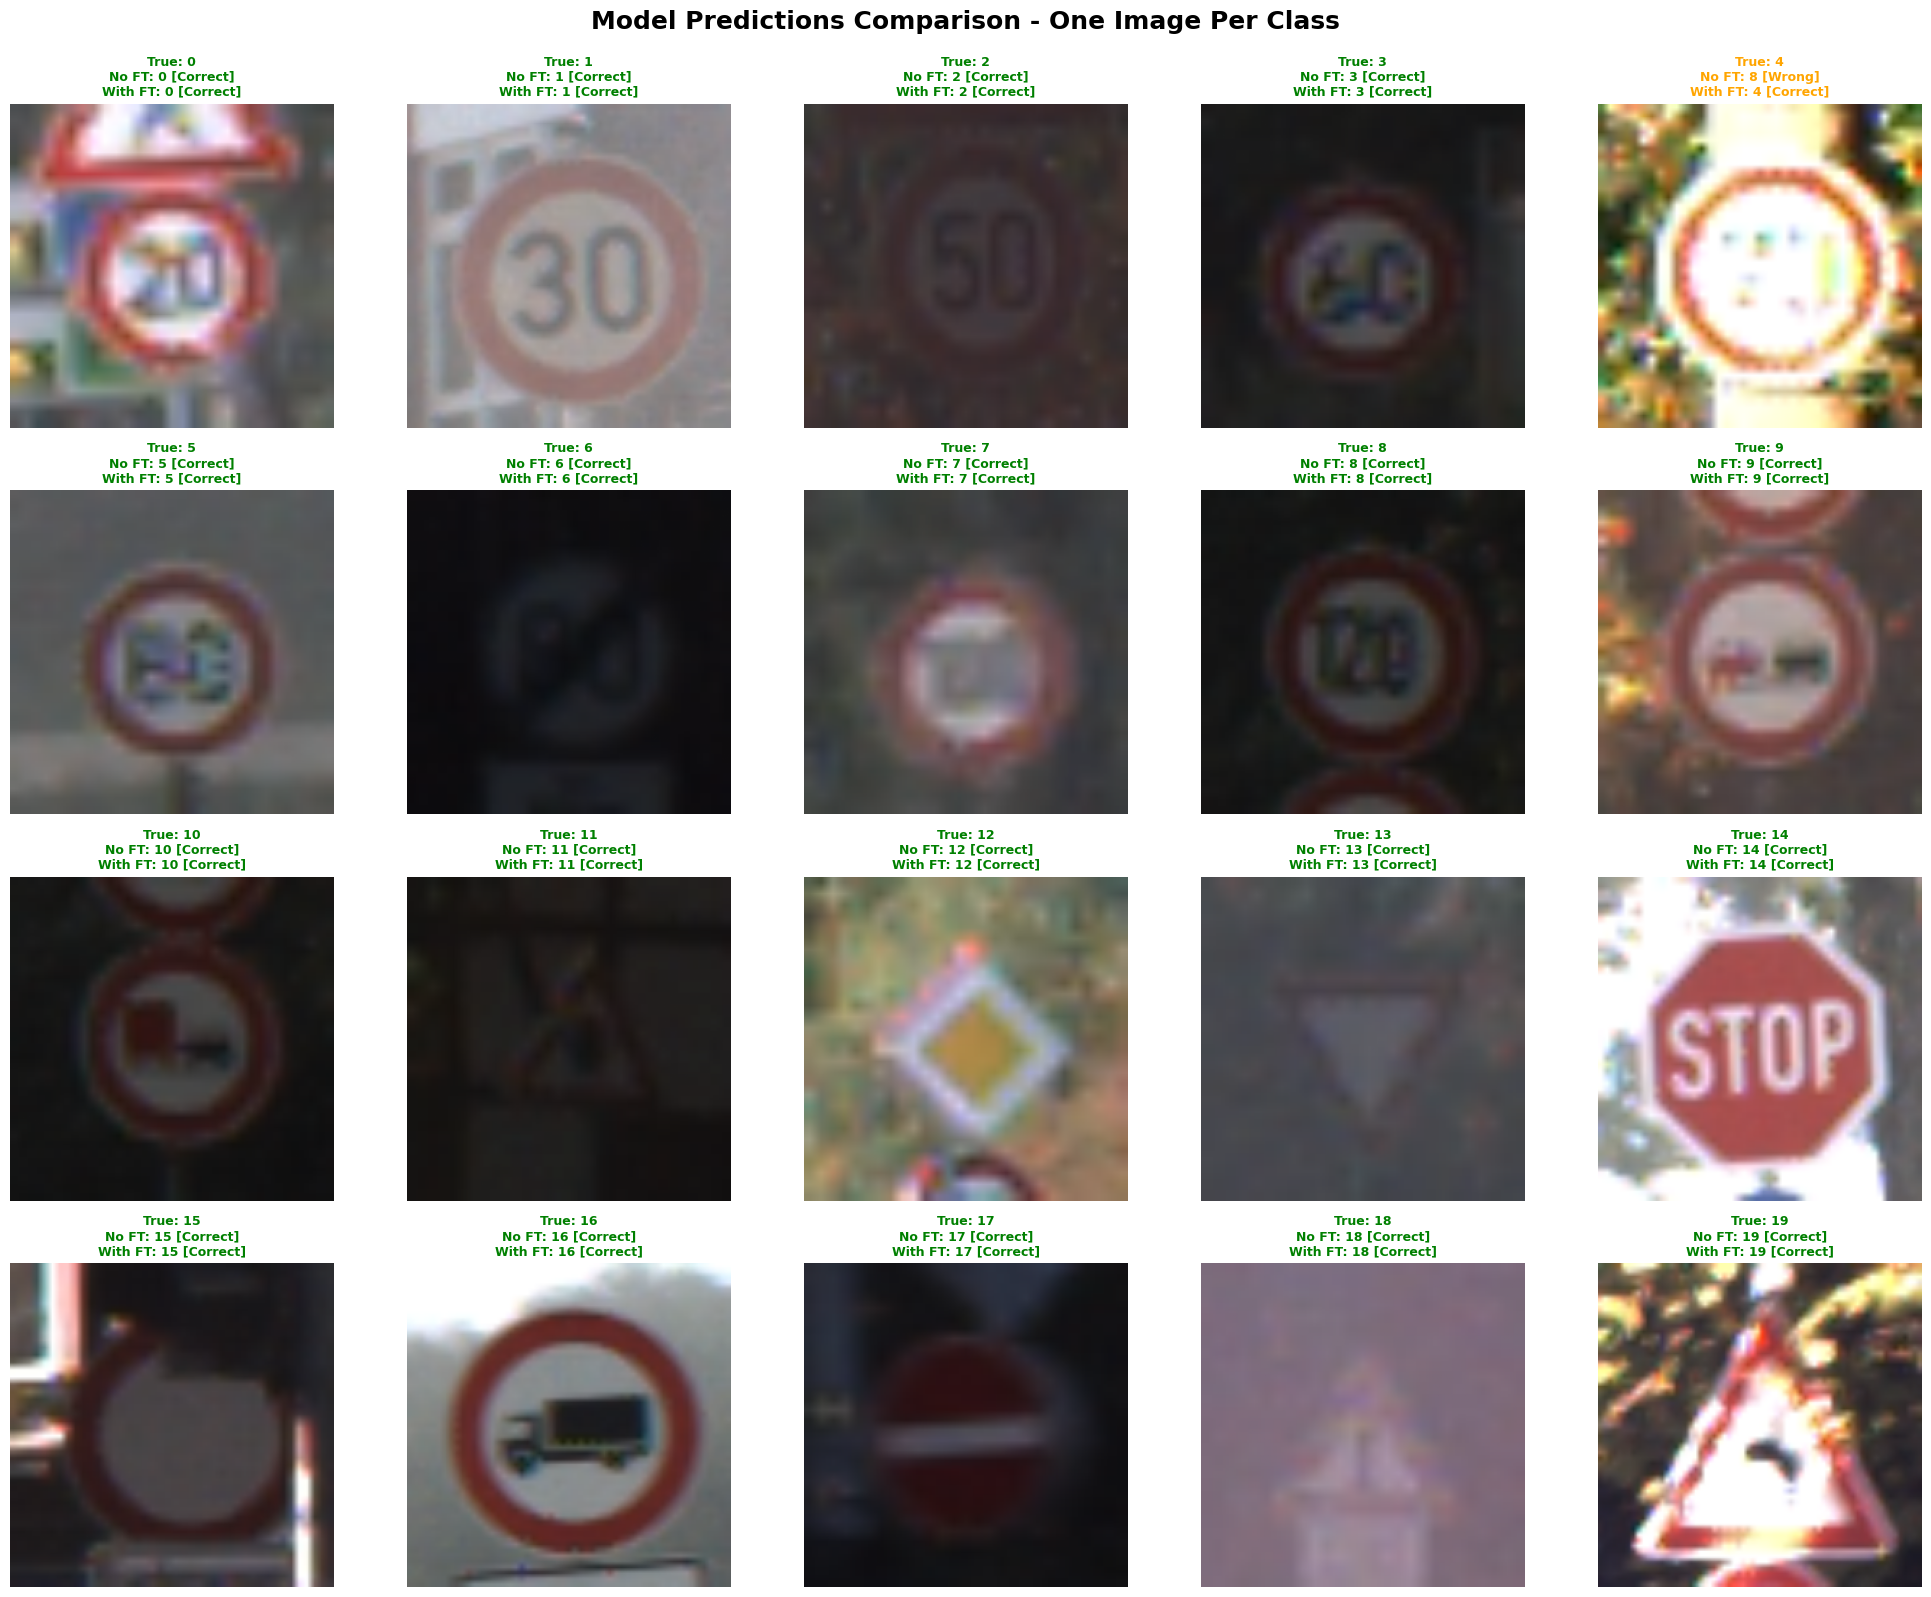


PREDICTIONS ON 20 DIFFERENT CLASSES
Classes tested: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Model WITHOUT fine-tuning: 19/20 correct (95.0%)
Model WITH fine-tuning: 20/20 correct (100.0%)

Legend:
  [Correct] = Correct prediction
  [Wrong] = Incorrect prediction
  Green = Both models correct
  Orange = One model correct
  Red = Both models wrong


In [17]:
# Make predictions on test images and compare both models

# Set models to evaluation mode
german_signs_model.eval()
german_signs_model_ft.eval()

# Collect one image from each class
print("Selecting one image from different classes...")
class_to_image = {}  # Dictionary to store one image per class
selected_images = []
selected_labels = []

# Iterate through test dataset to find one image per class
for images, labels in test_loader:
    for img, label in zip(images, labels):
        label_item = label.item()
        if label_item not in class_to_image:
            class_to_image[label_item] = img
            selected_images.append(img)
            selected_labels.append(label)
            
        # Stop when we have 20 different classes
        if len(class_to_image) >= 20:
            break
    if len(class_to_image) >= 20:
        break

# Convert to tensors
test_images = torch.stack(selected_images)
test_labels = torch.stack(selected_labels)

print(f"Selected {len(class_to_image)} images from different classes: {sorted(class_to_image.keys())}")
print("="*60)

# Detect device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Move models and data to device
german_signs_model = german_signs_model.to(device)
german_signs_model_ft = german_signs_model_ft.to(device)
test_images = test_images.to(device)

# Make predictions with both models
with torch.no_grad():
    # Model without fine-tuning
    outputs_no_ft = german_signs_model(test_images)
    _, predictions_no_ft = torch.max(outputs_no_ft, 1)
    
    # Model with fine-tuning
    outputs_ft = german_signs_model_ft(test_images)
    _, predictions_ft = torch.max(outputs_ft, 1)

# Move back to CPU for visualization
test_images = test_images.cpu()
predictions_no_ft = predictions_no_ft.cpu()
predictions_ft = predictions_ft.cpu()
test_labels = test_labels.cpu()

# Denormalization for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    """Reverse normalization for display."""
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    return img

# Create visualization figure
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('Model Predictions Comparison - One Image Per Class', fontsize=18, fontweight='bold', y=0.995)

# Display 20 test images with predictions (one from each class)
num_images = len(test_images)
for idx in range(num_images):
    row = idx // 5
    col = idx % 5
    
    # Prepare image
    img = denormalize(test_images[idx])
    img_np = img.permute(1, 2, 0).numpy()
    
    # Get labels and predictions
    true_label = test_labels[idx].item()
    pred_no_ft = predictions_no_ft[idx].item()
    pred_ft = predictions_ft[idx].item()
    
    # Display image
    axes[row, col].imshow(img_np)
    
    # Create title with color coding
    # Green: both correct | Orange: one correct | Red: both wrong
    if pred_no_ft == true_label and pred_ft == true_label:
        color = 'green'
        title = f'True: {true_label}\nNo FT: {pred_no_ft} [Correct]\nWith FT: {pred_ft} [Correct]'
    elif pred_no_ft == true_label or pred_ft == true_label:
        color = 'orange'
        no_ft_mark = '[Correct]' if pred_no_ft == true_label else '[Wrong]'
        ft_mark = '[Correct]' if pred_ft == true_label else '[Wrong]'
        title = f'True: {true_label}\nNo FT: {pred_no_ft} {no_ft_mark}\nWith FT: {pred_ft} {ft_mark}'
    else:
        color = 'red'
        title = f'True: {true_label}\nNo FT: {pred_no_ft} [Wrong]\nWith FT: {pred_ft} [Wrong]'
    
    axes[row, col].set_title(title, fontsize=9, fontweight='bold', color=color)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Calculate batch accuracy
correct_no_ft = (predictions_no_ft[:num_images] == test_labels[:num_images]).sum().item()
correct_ft = (predictions_ft[:num_images] == test_labels[:num_images]).sum().item()

print("\n" + "="*60)
print(f"PREDICTIONS ON {num_images} DIFFERENT CLASSES")
print("="*60)
print(f"Classes tested: {sorted([label.item() for label in test_labels])}")
print(f"Model WITHOUT fine-tuning: {correct_no_ft}/{num_images} correct ({100*correct_no_ft/num_images:.1f}%)")
print(f"Model WITH fine-tuning: {correct_ft}/{num_images} correct ({100*correct_ft/num_images:.1f}%)")
print("="*60)
print("\nLegend:")
print("  [Correct] = Correct prediction")
print("  [Wrong] = Incorrect prediction")
print("  Green = Both models correct")
print("  Orange = One model correct")
print("  Red = Both models wrong")
print("="*60)


# Compare the performance of both models
---

Plot the results of both models in the same figure.

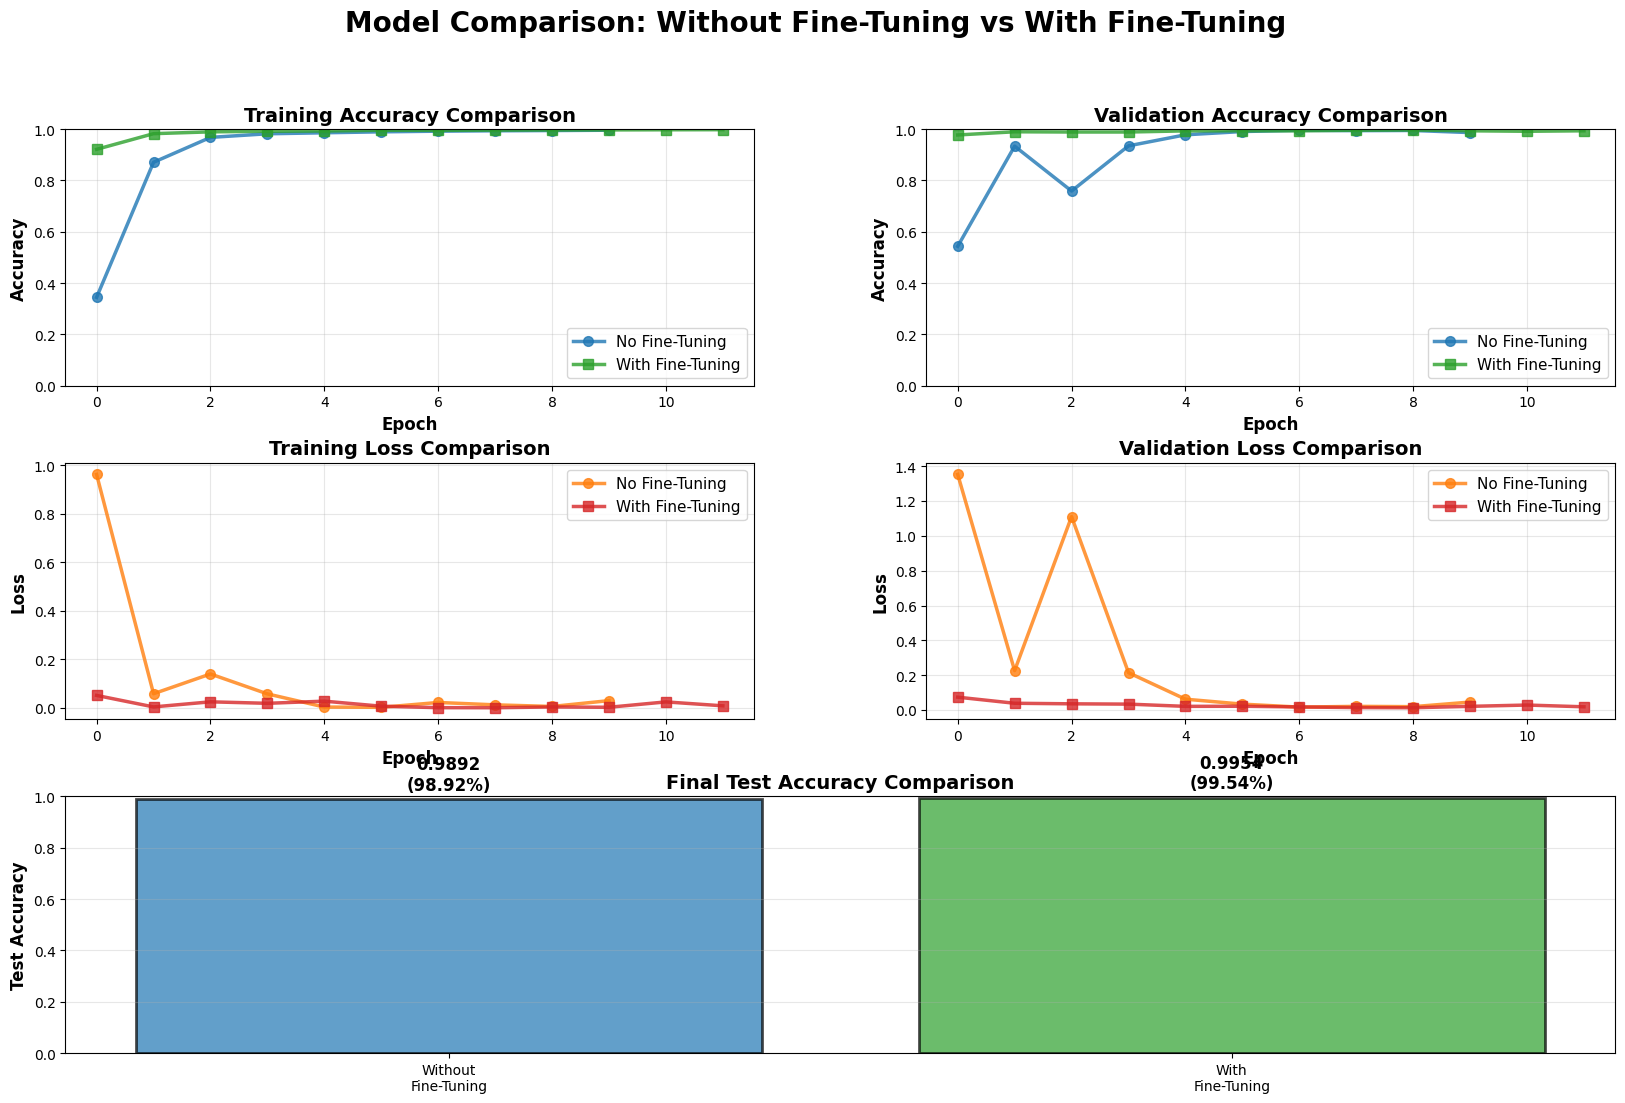


                         MODEL COMPARISON SUMMARY
Metric                              | No Fine-Tuning       | With Fine-Tuning    
--------------------------------------------------------------------------------
Final Training Accuracy             |             0.9956 |             0.9976
Final Validation Accuracy           |             0.9863 |             0.9933
Final Training Loss                 |             0.0296 |             0.0083
Final Validation Loss               |             0.0458 |             0.0186
--------------------------------------------------------------------------------
Best Validation Accuracy            |     0.9952 (ep 6) |     0.9965 (ep 8)
Best Validation Loss                |     0.0169 (ep 6) |     0.0132 (ep 8)
--------------------------------------------------------------------------------
Test Accuracy                       |             0.9892 |             0.9954
Test Accuracy (%)                   |             98.92% |             99.54%
----

In [22]:
# Comprehensive comparison of both models

# Load metrics from both training runs
metrics_path_no_ft = os.path.join(trainer.logger.log_dir, "metrics.csv")
metrics_df_no_ft = pd.read_csv(metrics_path_no_ft)
metrics_df_no_ft = metrics_df_no_ft.dropna(subset=['epoch'])

# Aggregate metrics properly for no fine-tuning model
epoch_metrics_no_ft = metrics_df_no_ft.groupby('epoch').agg({
    'train_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'train_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan
}).reset_index()
epoch_metrics_no_ft = epoch_metrics_no_ft.dropna(subset=['train_acc', 'val_acc', 'train_loss', 'val_loss'], how='all')

metrics_path_ft = os.path.join(trainer_ft.logger.log_dir, "metrics.csv")
metrics_df_ft = pd.read_csv(metrics_path_ft)
metrics_df_ft = metrics_df_ft.dropna(subset=['epoch'])

# Aggregate metrics properly for fine-tuning model
epoch_metrics_ft = metrics_df_ft.groupby('epoch').agg({
    'train_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_acc': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'train_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan,
    'val_loss': lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan
}).reset_index()
epoch_metrics_ft = epoch_metrics_ft.dropna(subset=['train_acc', 'val_acc', 'train_loss', 'val_loss'], how='all')

# Create comprehensive comparison figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

fig.suptitle('Model Comparison: Without Fine-Tuning vs With Fine-Tuning', 
             fontsize=20, fontweight='bold', y=0.98)

# Row 1: Training Accuracy
ax1 = fig.add_subplot(gs[0, 0])
if not epoch_metrics_no_ft['train_acc'].isna().all():
    ax1.plot(epoch_metrics_no_ft['epoch'], epoch_metrics_no_ft['train_acc'], 
             marker='o', label='No Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#1f77b4', alpha=0.8)
if not epoch_metrics_ft['train_acc'].isna().all():
    ax1.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['train_acc'], 
             marker='s', label='With Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#2ca02c', alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Row 1: Validation Accuracy
ax2 = fig.add_subplot(gs[0, 1])
if not epoch_metrics_no_ft['val_acc'].isna().all():
    ax2.plot(epoch_metrics_no_ft['epoch'], epoch_metrics_no_ft['val_acc'], 
             marker='o', label='No Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#1f77b4', alpha=0.8)
if not epoch_metrics_ft['val_acc'].isna().all():
    ax2.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['val_acc'], 
             marker='s', label='With Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#2ca02c', alpha=0.8)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# Row 2: Training Loss
ax3 = fig.add_subplot(gs[1, 0])
if not epoch_metrics_no_ft['train_loss'].isna().all():
    ax3.plot(epoch_metrics_no_ft['epoch'], epoch_metrics_no_ft['train_loss'], 
             marker='o', label='No Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#ff7f0e', alpha=0.8)
if not epoch_metrics_ft['train_loss'].isna().all():
    ax3.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['train_loss'], 
             marker='s', label='With Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#d62728', alpha=0.8)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax3.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11, loc='upper right')
ax3.grid(True, alpha=0.3)

# Row 2: Validation Loss
ax4 = fig.add_subplot(gs[1, 1])
if not epoch_metrics_no_ft['val_loss'].isna().all():
    ax4.plot(epoch_metrics_no_ft['epoch'], epoch_metrics_no_ft['val_loss'], 
             marker='o', label='No Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#ff7f0e', alpha=0.8)
if not epoch_metrics_ft['val_loss'].isna().all():
    ax4.plot(epoch_metrics_ft['epoch'], epoch_metrics_ft['val_loss'], 
             marker='s', label='With Fine-Tuning', linewidth=2.5, markersize=7, 
             color='#d62728', alpha=0.8)
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax4.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11, loc='upper right')
ax4.grid(True, alpha=0.3)

# Row 3: Test Accuracy Bar Chart
ax5 = fig.add_subplot(gs[2, :])
models = ['Without\nFine-Tuning', 'With\nFine-Tuning']
test_accuracies = [test_acc, test_acc_ft]
colors = ['#1f77b4', '#2ca02c']

bars = ax5.bar(models, test_accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax5.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax5.set_title('Final Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax5.set_ylim([0, 1])
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, test_accuracies):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{acc:.4f}\n({acc*100:.2f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# Print comprehensive comparison table
print("\n" + "="*80)
print(" " * 25 + "MODEL COMPARISON SUMMARY")
print("="*80)
print(f"{'Metric':<35} | {'No Fine-Tuning':<20} | {'With Fine-Tuning':<20}")
print("-"*80)

# Check if data is valid before printing
if not epoch_metrics_no_ft.empty and not epoch_metrics_ft.empty:
    # Final metrics
    print(f"{'Final Training Accuracy':<35} | {epoch_metrics_no_ft['train_acc'].iloc[-1]:>18.4f} | {epoch_metrics_ft['train_acc'].iloc[-1]:>18.4f}")
    print(f"{'Final Validation Accuracy':<35} | {epoch_metrics_no_ft['val_acc'].iloc[-1]:>18.4f} | {epoch_metrics_ft['val_acc'].iloc[-1]:>18.4f}")
    print(f"{'Final Training Loss':<35} | {epoch_metrics_no_ft['train_loss'].iloc[-1]:>18.4f} | {epoch_metrics_ft['train_loss'].iloc[-1]:>18.4f}")
    print(f"{'Final Validation Loss':<35} | {epoch_metrics_no_ft['val_loss'].iloc[-1]:>18.4f} | {epoch_metrics_ft['val_loss'].iloc[-1]:>18.4f}")
    print("-"*80)

    # Best metrics
    best_val_acc_no_ft = epoch_metrics_no_ft['val_acc'].max()
    best_val_acc_epoch_no_ft = epoch_metrics_no_ft.loc[epoch_metrics_no_ft['val_acc'].idxmax(), 'epoch']
    best_val_acc_ft = epoch_metrics_ft['val_acc'].max()
    best_val_acc_epoch_ft = epoch_metrics_ft.loc[epoch_metrics_ft['val_acc'].idxmax(), 'epoch']

    print(f"{'Best Validation Accuracy':<35} | {best_val_acc_no_ft:>10.4f} (ep {best_val_acc_epoch_no_ft:.0f}) | {best_val_acc_ft:>10.4f} (ep {best_val_acc_epoch_ft:.0f})")

    best_val_loss_no_ft = epoch_metrics_no_ft['val_loss'].min()
    best_val_loss_epoch_no_ft = epoch_metrics_no_ft.loc[epoch_metrics_no_ft['val_loss'].idxmin(), 'epoch']
    best_val_loss_ft = epoch_metrics_ft['val_loss'].min()
    best_val_loss_epoch_ft = epoch_metrics_ft.loc[epoch_metrics_ft['val_loss'].idxmin(), 'epoch']

    print(f"{'Best Validation Loss':<35} | {best_val_loss_no_ft:>10.4f} (ep {best_val_loss_epoch_no_ft:.0f}) | {best_val_loss_ft:>10.4f} (ep {best_val_loss_epoch_ft:.0f})")
    print("-"*80)

# Test accuracy
print(f"{'Test Accuracy':<35} | {test_acc:>18.4f} | {test_acc_ft:>18.4f}")
print(f"{'Test Accuracy (%)':<35} | {test_acc*100:>17.2f}% | {test_acc_ft*100:>17.2f}%")
print("-"*80)

# Model characteristics
print(f"{'Trainable Parameters':<35} | {'~11.3M (100%)':<20} | {'~2.8M (25%)':<20}")
print(f"{'Learning Rate':<35} | {'0.001':<20} | {'0.0001':<20}")
print(f"{'Training Strategy':<35} | {'All layers':<20} | {'Layer4 + FC only':<20}")
print("="*80)

# Determine winner
print("\n" + "="*80)
if test_acc_ft > test_acc:
    diff = (test_acc_ft - test_acc) * 100
    print(f"   WINNER: Model WITH Fine-Tuning (better by {diff:.2f}% on test set)")
elif test_acc > test_acc_ft:
    diff = (test_acc - test_acc_ft) * 100
    print(f"   WINNER: Model WITHOUT Fine-Tuning (better by {diff:.2f}% on test set)")
else:
    print(f"   TIE: Both models achieved the same test accuracy!")
print("="*80)

# Test the models on new images
---

Download new images of traffic signs, and test both models on the images. Download at least 5 images. Plot them with the predicted class.

Add a text cell with your conclusions on the performance of the models on the new images.

## Download new images, and make predictions on them.

Loading new traffic sign images from internet...
Found 10 images in Data_Tarea2/new_traffic_signs
  Loaded: image1.jpg
  Loaded: image10.jpg
  Loaded: image2.jpg
  Loaded: image3.jpeg
  Loaded: image4.jpeg
  Loaded: image5.jpeg
  Loaded: image6.jpg
  Loaded: image7.jpg
  Loaded: image8.jpg
  Loaded: image9.jpg

Successfully loaded 10 images


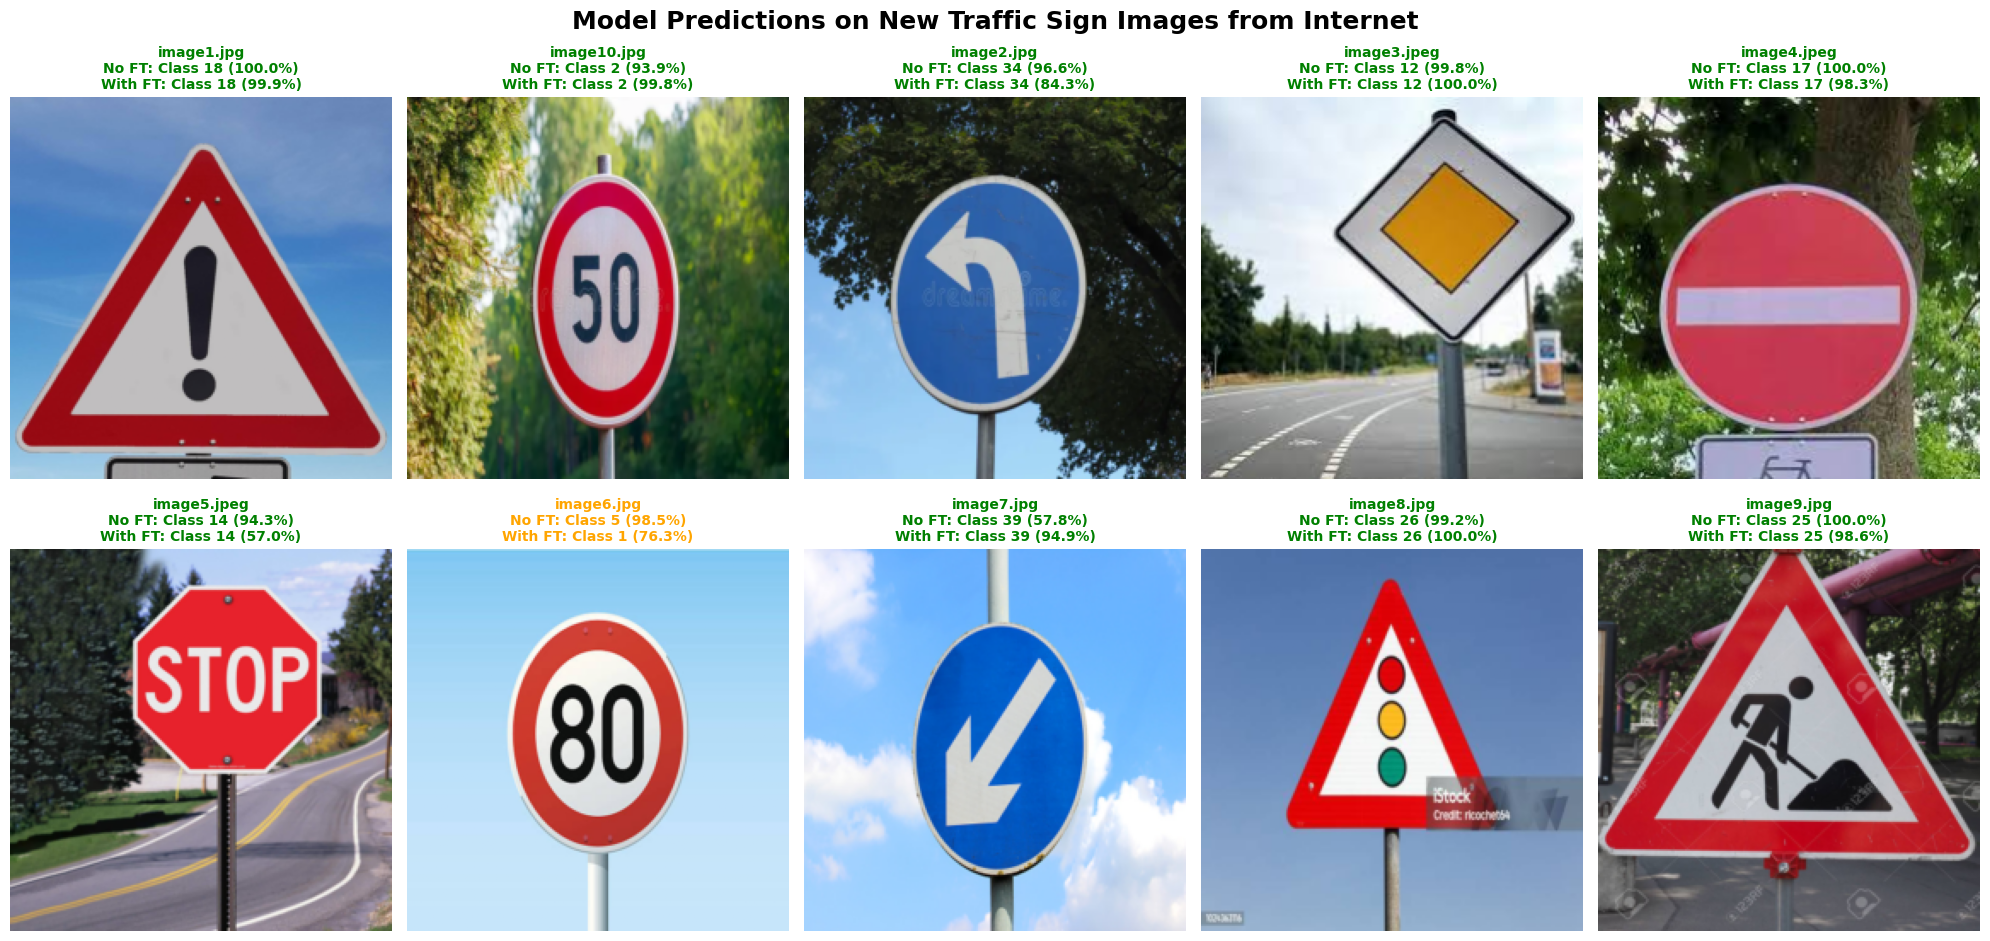


PREDICTIONS ON NEW IMAGES FROM INTERNET - DETAILED RESULTS
#     | Filename                       | No FT Pred   | Conf %     | FT Pred      | Conf %     | Agreement   
----------------------------------------------------------------------------------------------------
1     | image1.jpg                     | Class 18     |  100.0% | Class 18     |   99.9% | [AGREE]     
2     | image10.jpg                    | Class 2      |   93.9% | Class 2      |   99.8% | [AGREE]     
3     | image2.jpg                     | Class 34     |   96.6% | Class 34     |   84.3% | [AGREE]     
4     | image3.jpeg                    | Class 12     |   99.8% | Class 12     |  100.0% | [AGREE]     
5     | image4.jpeg                    | Class 17     |  100.0% | Class 17     |   98.3% | [AGREE]     
6     | image5.jpeg                    | Class 14     |   94.3% | Class 14     |   57.0% | [AGREE]     
7     | image6.jpg                     | Class 5      |   98.5% | Class 1      |   76.3% | [DISAGREE]  
8

In [19]:
# Test both models on new images downloaded from the internet

# Load images from the new_traffic_signs directory
new_images_dir = 'Data_Tarea2/new_traffic_signs'

print("Loading new traffic sign images from internet...")
print("="*60)

# Get all image files from the directory
image_files = sorted(glob.glob(os.path.join(new_images_dir, '*.*')))
image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm', '.svg'))]

print(f"Found {len(image_files)} images in {new_images_dir}")

if len(image_files) == 0:
    raise FileNotFoundError(f"No images found in {new_images_dir}. Please add images to this directory.")

# Load and preprocess each image
new_images_list = []
image_names = []

for img_path in image_files:
    # Load image
    img = Image.open(img_path).convert('RGB')
    
    # Apply test transformations (resize, normalize)
    img_tensor = test_transform(img)
    new_images_list.append(img_tensor)
    image_names.append(os.path.basename(img_path))
    
    print(f"  Loaded: {os.path.basename(img_path)}")

# Stack into batch
new_images_batch = torch.stack(new_images_list)
num_new_images = len(new_images_list)

print(f"\nSuccessfully loaded {num_new_images} images")
print("="*60)

# Set models to evaluation mode
german_signs_model.eval()
german_signs_model_ft.eval()

# Detect device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Move to device
german_signs_model = german_signs_model.to(device)
german_signs_model_ft = german_signs_model_ft.to(device)
new_images_batch = new_images_batch.to(device)

# Make predictions with confidence scores
with torch.no_grad():
    # Model without fine-tuning
    outputs_no_ft = german_signs_model(new_images_batch)
    probs_no_ft = torch.nn.functional.softmax(outputs_no_ft, dim=1)
    confidences_no_ft, predictions_no_ft = torch.max(probs_no_ft, 1)
    
    # Model with fine-tuning
    outputs_ft = german_signs_model_ft(new_images_batch)
    probs_ft = torch.nn.functional.softmax(outputs_ft, dim=1)
    confidences_ft, predictions_ft = torch.max(probs_ft, 1)

# Move back to CPU
new_images_batch = new_images_batch.cpu()
predictions_no_ft = predictions_no_ft.cpu()
predictions_ft = predictions_ft.cpu()
confidences_no_ft = confidences_no_ft.cpu()
confidences_ft = confidences_ft.cpu()

# Denormalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img):
    """Reverse normalization for display."""
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    return img

# Create visualization - adjust grid based on number of images
if num_new_images <= 5:
    rows, cols = 1, 5
elif num_new_images <= 10:
    rows, cols = 2, 5
else:
    rows, cols = 3, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)
fig.suptitle('Model Predictions on New Traffic Sign Images from Internet', fontsize=18, fontweight='bold', y=0.98)

for idx in range(min(num_new_images, rows*cols)):
    row = idx // cols
    col = idx % cols
    
    # Prepare image
    img = denormalize(new_images_batch[idx])
    img_np = img.permute(1, 2, 0).numpy()
    
    # Get predictions
    pred_no_ft = predictions_no_ft[idx].item()
    pred_ft = predictions_ft[idx].item()
    conf_no_ft = confidences_no_ft[idx].item()
    conf_ft = confidences_ft[idx].item()
    
    # Display image
    axes[row, col].imshow(img_np)
    
    # Create title with predictions (no true labels since these are from internet)
    title = f'{image_names[idx]}\n'
    title += f'No FT: Class {pred_no_ft} ({conf_no_ft*100:.1f}%)\n'
    title += f'With FT: Class {pred_ft} ({conf_ft*100:.1f}%)'
    
    # Color code by agreement
    if pred_no_ft == pred_ft:
        color = 'green'  # Both models agree
        border_color = 'green'
    else:
        color = 'orange'  # Models disagree
        border_color = 'orange'
    
    axes[row, col].set_title(title, fontsize=10, fontweight='bold', color=color)
    axes[row, col].axis('off')
    
    # Add colored border
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

# Hide unused subplots
for idx in range(num_new_images, rows*cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

# Print detailed results table
print("\n" + "="*100)
print("PREDICTIONS ON NEW IMAGES FROM INTERNET - DETAILED RESULTS")
print("="*100)
print(f"{'#':<5} | {'Filename':<30} | {'No FT Pred':<12} | {'Conf %':<10} | {'FT Pred':<12} | {'Conf %':<10} | {'Agreement':<12}")
print("-"*100)

for idx in range(num_new_images):
    pred_no_ft = predictions_no_ft[idx].item()
    pred_ft = predictions_ft[idx].item()
    conf_no_ft = confidences_no_ft[idx].item() * 100
    conf_ft = confidences_ft[idx].item() * 100
    
    agreement = "[AGREE]" if pred_no_ft == pred_ft else "[DISAGREE]"
    
    filename = image_names[idx][:28] + '..' if len(image_names[idx]) > 30 else image_names[idx]
    print(f"{idx+1:<5} | {filename:<30} | Class {pred_no_ft:<6} | {conf_no_ft:>6.1f}% | Class {pred_ft:<6} | {conf_ft:>6.1f}% | {agreement:<12}")

print("-"*100)

# Calculate agreement statistics
agreement_count = sum([1 for i in range(num_new_images) if predictions_no_ft[i] == predictions_ft[i]])
print(f"\nModel Agreement Statistics:")
print(f"   Both models agree: {agreement_count}/{num_new_images} ({100*agreement_count/num_new_images:.1f}%)")
print(f"   Models disagree:   {num_new_images-agreement_count}/{num_new_images} ({100*(num_new_images-agreement_count)/num_new_images:.1f}%)")

# Show most confident predictions
print(f"\nHighest Confidence Predictions:")
print(f"   Model WITHOUT Fine-Tuning: {confidences_no_ft.max()*100:.1f}% (Image #{confidences_no_ft.argmax().item()+1})")
print(f"   Model WITH Fine-Tuning:    {confidences_ft.max()*100:.1f}% (Image #{confidences_ft.argmax().item()+1})")

print("="*100)
print("\nLegend:")
print("  [AGREE] = Both models predict the same class")
print("  [DISAGREE] = Models predict different classes")
print("  Green border = Models agree on prediction")
print("  Orange border = Models disagree on prediction")
print("="*100)


## Conclusions

* The **model without fine-tuning** (all ResNet18 layers trainable, higher learning rate) reached a **validation accuracy of 0.9952** and a **test accuracy of 0.9892 (98.92%)**. 
* The **fine-tuned model** (early layers frozen, only layer4 + FC trainable, lower learning rate) reached a **best validation accuracy of 0.9965** and a **test accuracy of 0.9954 (99.54%)**.

Both models therefore achieve very high performance on the German Traffic Sign classification task, with the fine-tuned model slightly ahead on aggregate metrics.


On a small set of new external images, both models performed very well and usually agreed:
* The models **agreed on 9 out of 10 images (90%)**.
* In the **single disagreement**, the **model without fine-tuning predicted the correct class (class 5)**, while the fine-tuned model misclassified it as class 1. 
* In general, both models showed high confidence, and when they agreed, they were correct in all examined cases.

This shows that the fine-tuned model is not uniformly better on every single example, even though its global metrics are higher.

* The **no-fine-tuning model** trains **~11.2M parameters (100%)**.
* The **fine-tuned model** trains only **~2.8M parameters (~25%)**, keeping ~8.4M parameters frozen, while still achieving better validation and test accuracy. 

This indicates that using transfer learning with partial fine-tuning can be more parameter-efficient while still improving performance.

Both approaches are successful and robust for traffic sign classification:

* The **no-fine-tuning model** is strong, slightly simpler conceptually, and even wins in at least one difficult external example.
* The **fine-tuned model** offers **slightly better overall accuracy with fewer trainable parameters**, making it the preferable strategy when balancing performance and efficiency.